### Copy and Rename last state and weight from simulations

In [1]:
import glob
import shutil
import os

#list up folders in simulation
folders = sorted(glob.glob("./quantum/*_Zone-*/"))
print(f'There are {len(folders)} folders.')

#get last states and weights
for folder in folders:
    try:
        fns = sorted(glob.glob(folder+'state*/sim*100.csv'))[-1]
        fnw = sorted(glob.glob(folder+'weights/*.csv'))[-1]
    except:
        print(f'SKIPPED: {fns}')
        print('---')
        continue
    
    #get case as strings
    zone = fns.split('-')[1]
    eta = fns.split('-')[2]
    evac = fns.split('/s')[0].split('-')[-1] #fns.split('_')[3]
    if eta == 'mssd':
        print(f'SKIPPED: {fns}')
        print('---')
        continue
    else:
        print(f'Case: Zone {zone} - ETA {eta} - EVAC {evac}')
    
    #copy files
    dfs = './database/states'
    dfw = './database/weights'
    shutil.copy(fns,dfs)
    shutil.copy(fnw,dfw)
    
    #rename files
    file_name = fns.split('/')[-1]
    try:
        os.rename(f'./database/states/{file_name}',f'./database/states/z{zone}_eta{eta}_evac{evac}_{file_name}')
    except:
        pass
    
    file_name = fnw.split('/')[-1]
    try:
        os.rename(f'./database/weights/{file_name}',f'./database/weights/z{zone}_eta{eta}_evac{evac}_{file_name}')
    except:
        pass
    print('---')


There are 116 folders.
Case: Zone 1 - ETA 15 - EVAC 5
---
Case: Zone 1 - ETA 15 - EVAC 10
---
Case: Zone 1 - ETA 30 - EVAC 5
---
Case: Zone 1 - ETA 30 - EVAC 10
---
Case: Zone 1 - ETA 30 - EVAC 15
---
Case: Zone 1 - ETA 30 - EVAC 20
---
Case: Zone 1 - ETA 30 - EVAC 25
---
Case: Zone 1 - ETA 60 - EVAC 5
---
Case: Zone 1 - ETA 60 - EVAC 10
---
Case: Zone 1 - ETA 60 - EVAC 15
---
Case: Zone 1 - ETA 60 - EVAC 20
---
Case: Zone 1 - ETA 60 - EVAC 25
---
Case: Zone 1 - ETA 60 - EVAC 30
---
Case: Zone 1 - ETA 60 - EVAC 35
---
Case: Zone 1 - ETA 60 - EVAC 40
---
Case: Zone 1 - ETA 60 - EVAC 45
---
Case: Zone 1 - ETA 60 - EVAC 50
---
Case: Zone 1 - ETA 60 - EVAC 55
---
Case: Zone 1 - ETA 60 - EVAC 1
---
Case: Zone 1 - ETA 30 - EVAC 1
---
Case: Zone 1 - ETA 15 - EVAC 1
---
SKIPPED: ./quantum/1670287303382_Zone-1-mssd-c0-15-10/state_15_10_100/sim_000000100.csv
---
SKIPPED: ./quantum/1670288167693_Zone-1-mssd-c6-15-10/state_15_10_100/sim_000000100.csv
---
SKIPPED: ./quantum/1670288280195_Zone-1-mss

### Move video files to corresponding folder

In [2]:
import glob
import shutil

#move videos to corresponding folder
videos = sorted(glob.glob('./quantum/*.mp4'))
for video in videos:
    vf = video.split('_sim')[0]
    shutil.move(video,f'{vf}/.')

### Matching of case by looking at population distribution

In [ ]:
#The real-time data needs to be dissagregated to points, then re-aggregated as a mesh (geojson)
#export the geojson to tiff?
#compare

#imports
import pandas as pd
import numpy as np
import geopandas as gpd
import glob

#1. Real-time data
mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
mesh = gpd.read_file(mssds[0])
meshp = mesh.to_crs(6690)
#!==> Need to disaggregate and re-aggregate this one

#2. Database zone 1
db_mss = sorted(glob.glob('./quantum/*Zone-1-mssd*/results/agents_startcondition.csv')) #a list
db_cen = sorted(glob.glob('./quantum/*/results/agents_startcondition.csv'))[0] #one string

def aggregate_points_to_mesh(point_file:str,crs:int):
    df = pd.read_csv(point_file,header=None,names=['lon','lat'],usecols=[0,1])
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(x=df['lon'],y=df['lat']),crs=crs)
    gdf['value']=[1]*gdf.shape[0]
    gdf['column']=['agents']*gdf.shape[0]
    #Join
    dfsjoin = gpd.sjoin(gdf,meshp) #Spatial join Points to polygons
    #Aggregate
    dfpivot = pd.pivot_table(dfsjoin,values='value',columns=['column'],
                            index='MESH4_ID',aggfunc=np.sum,dropna=False,fill_value=0)
    dfpolynew = meshp.merge(dfpivot, how='left', on='MESH4_ID',)
    dfpolynew.plot(column='agents',cmap='viridis',missing_kwds= dict(color = "lightgrey"))  
    return dfpolynew





### Plot cases

<Axes: >

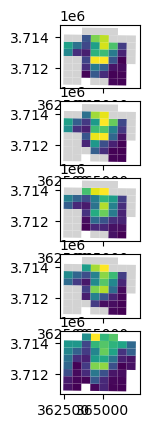

In [3]:
#Convert database of population to 500m grid
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import glob

breakat = 4 #len(files)
files = sorted(glob.glob('./quantum/*mssd*/results/agents_startcondition.csv'))
remain = len(files)-breakat
fig, axs = plt.subplots(breakat+1,1)
#get a mesh of the area
mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
mesh = gpd.read_file(mssds[0])
meshp = mesh.to_crs(6690)
for i,file in enumerate(files):
    if i == breakat:
        break
    df = pd.read_csv(file,header=None,names=['lon','lat'],usecols=[0,1])
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(x=df['lon'],y=df['lat']),crs=6690)
    gdf['value']=[1]*gdf.shape[0]
    gdf['column']=['agents']*gdf.shape[0]
    #Join
    dfsjoin = gpd.sjoin(gdf,meshp) #Spatial join Points to polygons
    #Aggregate
    dfpivot = pd.pivot_table(dfsjoin,values='value',columns=['column'],
                            index='MESH4_ID',aggfunc=np.sum,dropna=False,fill_value=0)
    dfpolynew = meshp.merge(dfpivot, how='left', on='MESH4_ID',)  
    dfpolynew.plot(ax=axs[i],column='agents',cmap='viridis',missing_kwds= dict(color = "lightgrey"))
meshp.plot(ax=axs[breakat],column='population',cmap='viridis',missing_kwds= dict(color = "lightgrey"))

<AxesSubplot: >

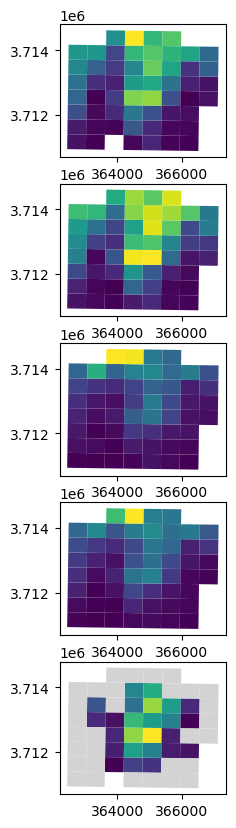

In [88]:
import matplotlib.pyplot as plt
import glob

mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
fig, axs = plt.subplots(len(mssds)+1,1,figsize=(50,10))
for i, mss in enumerate(mssds):
    mesh = gpd.read_file(mss)
    meshp = mesh.to_crs(6690)
    meshp.plot(ax=axs[i],column='population',cmap='viridis',missing_kwds= dict(color = "lightgrey"))
dfpolynew.plot(ax=axs[len(mssds)],column='agents',cmap='viridis',missing_kwds= dict(color = "lightgrey"))

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import glob

#1. Real-time data
mssds = glob.glob("/Volumes/Pegasus32/kochi/zones/zone01/*mssd*.geojson")
mesh = gpd.read_file(mssds[0])
meshp = mesh.to_crs(6690)

In [2]:
meshp.explore()